In [3]:
!pip install -q  pymorphy2 nltk pandas matplotlib seaborn wordcloud spacy

In [9]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.util import ngrams
import spacy
from spacy.lang.ru.examples import sentences

import inspect
# 
# if not hasattr(inspect, 'getargspec'):
#     inspect.getargspec = inspect.getfullargspec

In [5]:
# Настройка стилей графиков
sns.set(style="whitegrid")

# Загрузка данных из CSV
file_path = 'data/news.csv' 
df = pd.read_csv(file_path, delimiter=';')
df['content'] = df['content'].fillna('')

# Преобразование строк в списки с учетом пустых ячеек
def convert_links(links):
    if pd.isna(links) or links.strip() == '':
        return []  
    return ast.literal_eval(links)
# Преобразование строк в списки
df['post_links'] = df['post_links'].apply(convert_links)

# Преобразование столбца 'date' в datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y %H:%M')


In [35]:
df.shape

(8607, 10)

In [36]:
# Просмотр первых нескольких строк датасета
print("Первые 5 строк датасета:")
df.head()


Первые 5 строк датасета:


,id,source_type,title,content,link,date,tags,post_links,source_link,source_name
0,1,dzen,Количество раненых при нападении на магазин в ...,Число пострадавших при нападении посетителя с ...,https://dzen.ru/news/story/45396279-888c-507f-...,2024-10-25 14:30:00,index,"[https://vz.ru/news/2024/10/25/1294420.html, h...",https://vz.ru/news/2024/10/25/1294420.html,vz
1,2,dzen,Набиуллина: ипотечные ставки начнут снижаться ...,"""По мере снижения инфляции ипотечные ставки бу...",https://dzen.ru/news/story/1c02c1ba-4c7d-5c07-...,2024-10-25 15:49:00,index,[https://realty.ria.ru/20241025/stavki-1980109...,https://realty.ria.ru/20241025/stavki-19801093...,ria
2,3,dzen,RT выяснил личность подозреваемого в рабовладе...,"Как удалось выяснить, фигурант дела — 40-летни...",https://dzen.ru/news/story/3e598c32-677a-5e33-...,2024-10-25 15:20:00,index,[https://russian.rt.com/russia/news/1387351-li...,https://russian.rt.com/russia/news/1387351-lic...,russian.rt
3,4,dzen,ТАСС: войска Украины пытаются покинуть Селидово,Подразделения Вооруженных сил Украины (ВСУ) пр...,https://dzen.ru/news/story/f7ba2bed-7abf-506c-...,2024-10-25 15:03:00,index,[https://lenta.ru/news/2024/10/25/stalo-izvest...,https://lenta.ru/news/2024/10/25/stalo-izvestn...,lenta
4,5,dzen,Умер режиссер первых серий «Улиц разбитых фона...,Российский режиссер и сценарист Игорь Москвити...,https://dzen.ru/news/story/f7ebd12d-543d-5214-...,2024-10-25 14:52:00,index,"[https://www.kommersant.ru/doc/7263953, https:...",https://www.kommersant.ru/doc/7263953,kommersant


In [37]:
# Вывод общей информации о датасете
print("\nОбщая информация о датасете:")
df.info()



Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8607 entries, 0 to 8606
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           8607 non-null   int64         
 1   source_type  8607 non-null   object        
 2   title        8400 non-null   object        
 3   content      8607 non-null   object        
 4   link         8562 non-null   object        
 5   date         8560 non-null   datetime64[ns]
 6   tags         6434 non-null   object        
 7   post_links   8607 non-null   object        
 8   source_link  1481 non-null   object        
 9   source_name  3445 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 672.5+ KB


In [38]:
# Вывод статистики по данным
print("\nСтатистика по количественным данным:")
df.describe(include='all')


Статистика по количественным данным:


,id,source_type,title,content,link,date,tags,post_links,source_link,source_name
count,8607.000000,8607,8400,8607,8562,8560,6434,8607,1481,3445
unique,NaN,6,7002,7147,7581,NaN,799,2690,1094,529
top,NaN,pulse,"""ВТБ Мои Инвестиции"" обновили топ-10 российски...",,https://www.tbank.ru/invest/social/profile/Fom...,NaN,"новости, политика, расследование, репортаж, ин...",[],https://ria.ru/20241025/stavka-1980100194.html,tass
freq,NaN,3973,29,305,7,NaN,846,4455,7,1262
mean,4223.670965,NaN,NaN,NaN,NaN,2024-05-29 02:16:41.018691584,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,2019-02-25 16:38:00,NaN,NaN,NaN,NaN
25%,2152.500000,NaN,NaN,NaN,NaN,2024-03-14 10:18:00,NaN,NaN,NaN,NaN
50%,4304.000000,NaN,NaN,NaN,NaN,2024-09-02 12:37:00,NaN,NaN,NaN,NaN
75%,6455.500000,NaN,NaN,NaN,NaN,2024-10-25 02:23:00,NaN,NaN,NaN,NaN
max,7776.000000,NaN,NaN,NaN,NaN,2024-10-28 10:16:00,NaN,NaN,NaN,NaN


In [39]:
# Проверка на пропуски
print("\nПроверка на пропуски в данных:")
df.isnull().sum()


Проверка на пропуски в данных:


id                0
source_type       0
title           207
content           0
link             45
date             47
tags           2173
post_links        0
source_link    7126
source_name    5162
dtype: int64

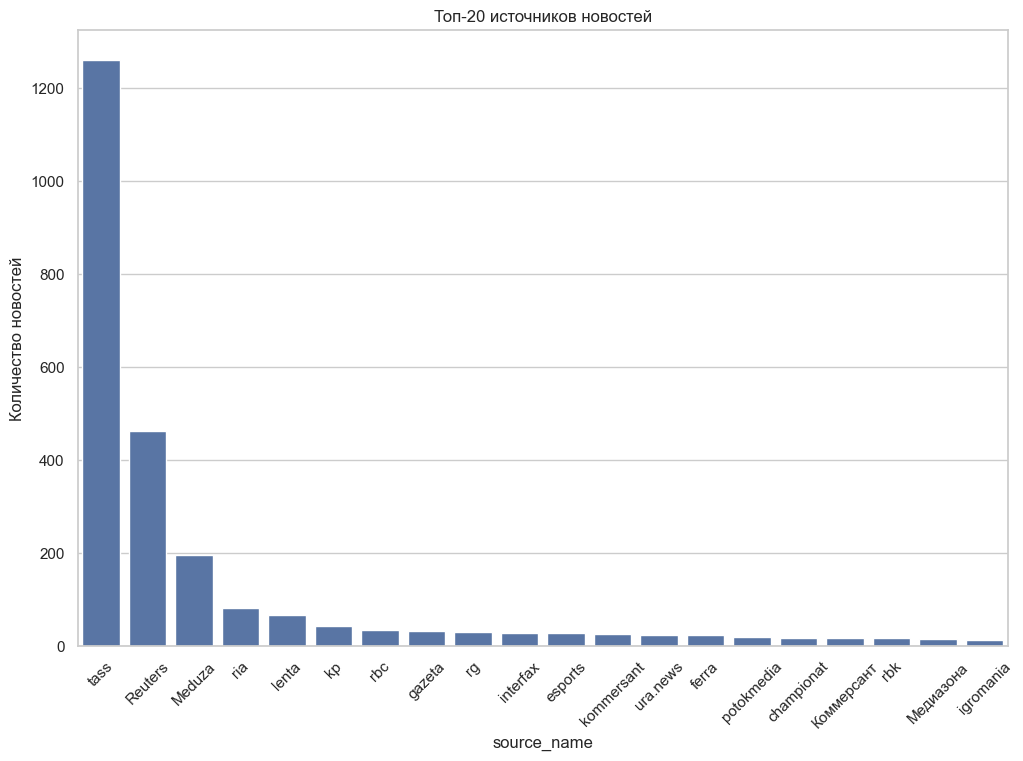

In [40]:
# Распределение новостей по источникам (топ-20)
plt.figure(figsize=(12, 8))
top_sources = df['source_name'].value_counts().nlargest(20)
# Построение графика
sns.countplot(data=df[df['source_name'].isin(top_sources.index)], x='source_name', order=top_sources.index)
plt.title('Топ-20 источников новостей')
plt.xticks(rotation=45)
plt.ylabel('Количество новостей')
plt.show()

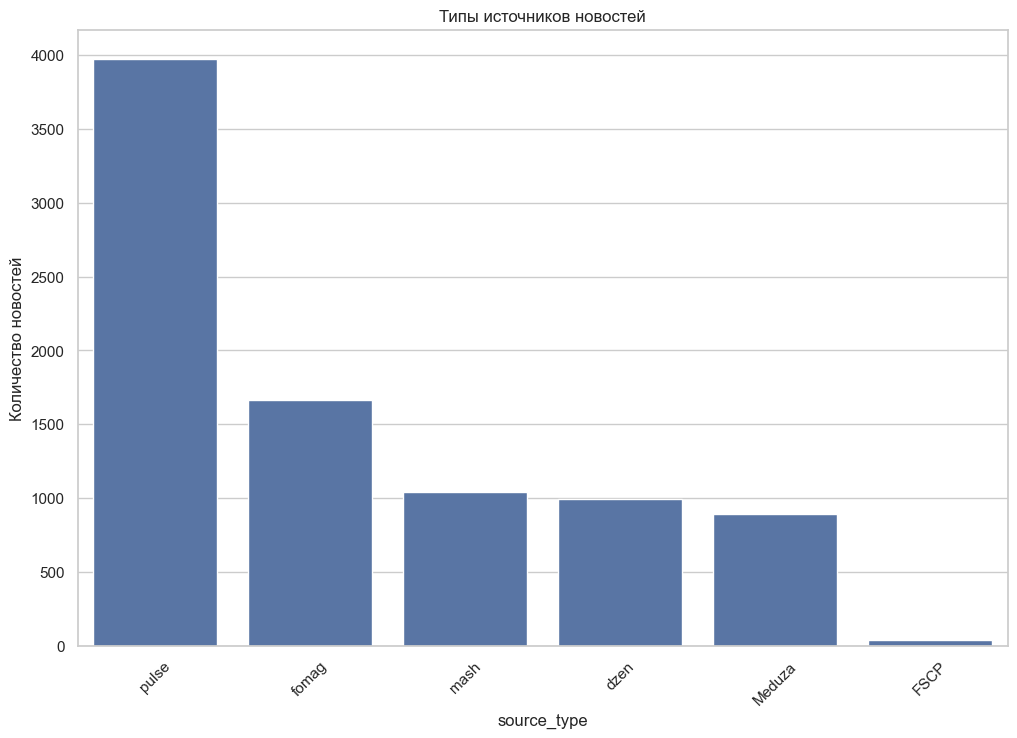

In [41]:
# Распределение новостей по источникам (топ-10)
plt.figure(figsize=(12, 8))

# Получаем топ-10 источников
top_sources = df['source_type'].value_counts().nlargest(10)

# Построение графика
sns.countplot(data=df[df['source_type'].isin(top_sources.index)], x='source_type', order=top_sources.index)
plt.title('Типы источников новостей')
plt.xticks(rotation=45)
plt.ylabel('Количество новостей')
plt.show()

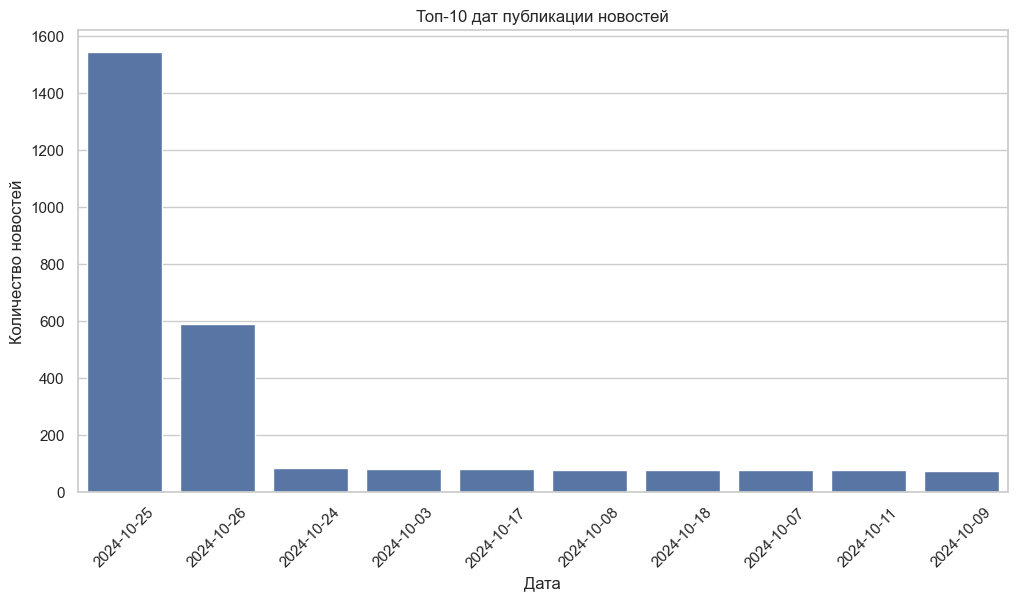

In [42]:
df['publish_date'] = df['date'].dt.date      # Оставляем только дату
df['publish_time'] = df['date'].dt.time      # Оставляем только время

# График распределения новостей по датам (топ-10)
plt.figure(figsize=(12, 6))

# Получаем топ-10 дат
top_dates = df['publish_date'].value_counts().nlargest(10)

# Построение графика для топ-10 дат
sns.countplot(data=df[df['publish_date'].isin(top_dates.index)], x='publish_date', order=top_dates.index)
plt.title('Топ-10 дат публикации новостей')
plt.xticks(rotation=45)
plt.ylabel('Количество новостей')
plt.xlabel('Дата')
plt.show()

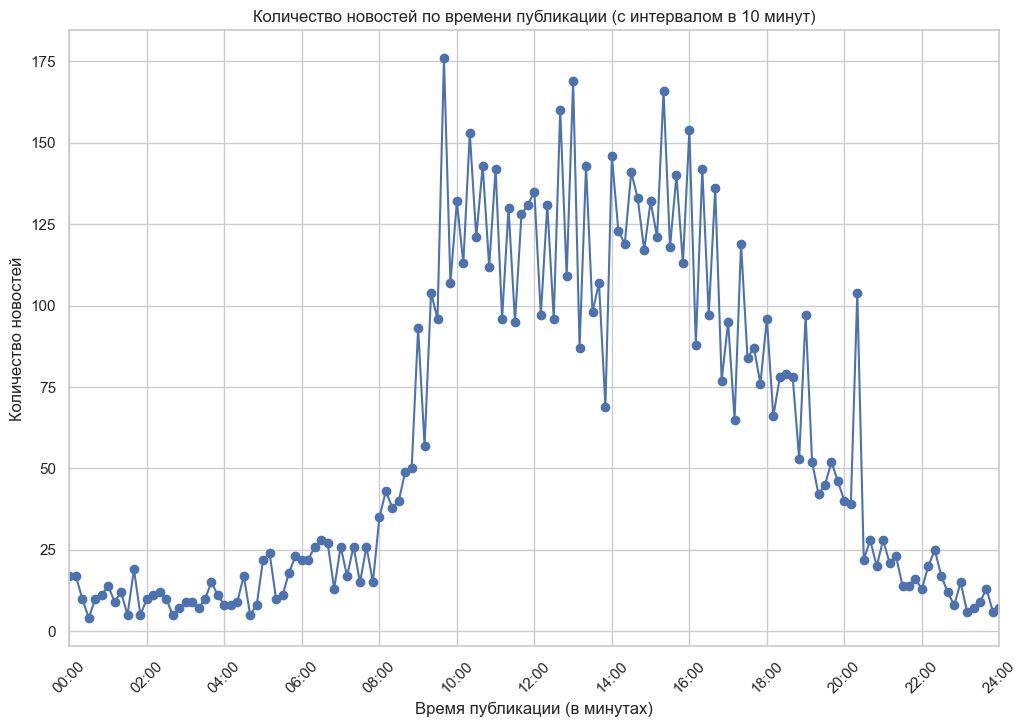

In [43]:
# Округление времени до ближайших 10 минут 
df['publish_time_10min'] = df['date'].dt.floor('10min').dt.time 

# Преобразуем время в минуты с начала суток
df['time_in_minutes'] = df['date'].dt.hour * 60 + df['date'].dt.minute + df['date'].dt.second / 60
df['time_in_minutes'] = df['time_in_minutes'].round(-1) 

# Группировка по округленным минутам и подсчет количества постов
time_counts = df['time_in_minutes'].value_counts().sort_index()
time_counts_df = time_counts.reset_index()
time_counts_df.columns = ['time_in_minutes', 'post_count']

# Построение линейного графика
plt.figure(figsize=(12, 8))
plt.plot(time_counts_df['time_in_minutes'], time_counts_df['post_count'], marker='o', linestyle='-')
plt.title('Количество новостей по времени публикации (с интервалом в 10 минут)')
plt.xlabel('Время публикации (в минутах)')
plt.ylabel('Количество новостей')

# Настройка шкалы времени: отображение меток каждые 2 часа
xticks_positions = range(0, 1441, 120) 
xticks_labels = [(f"{int(x//60):02}:{int(x%60):02}") for x in xticks_positions]  # Формат HH:MM

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.xlim(0, 1440)
plt.grid(True)
plt.show()

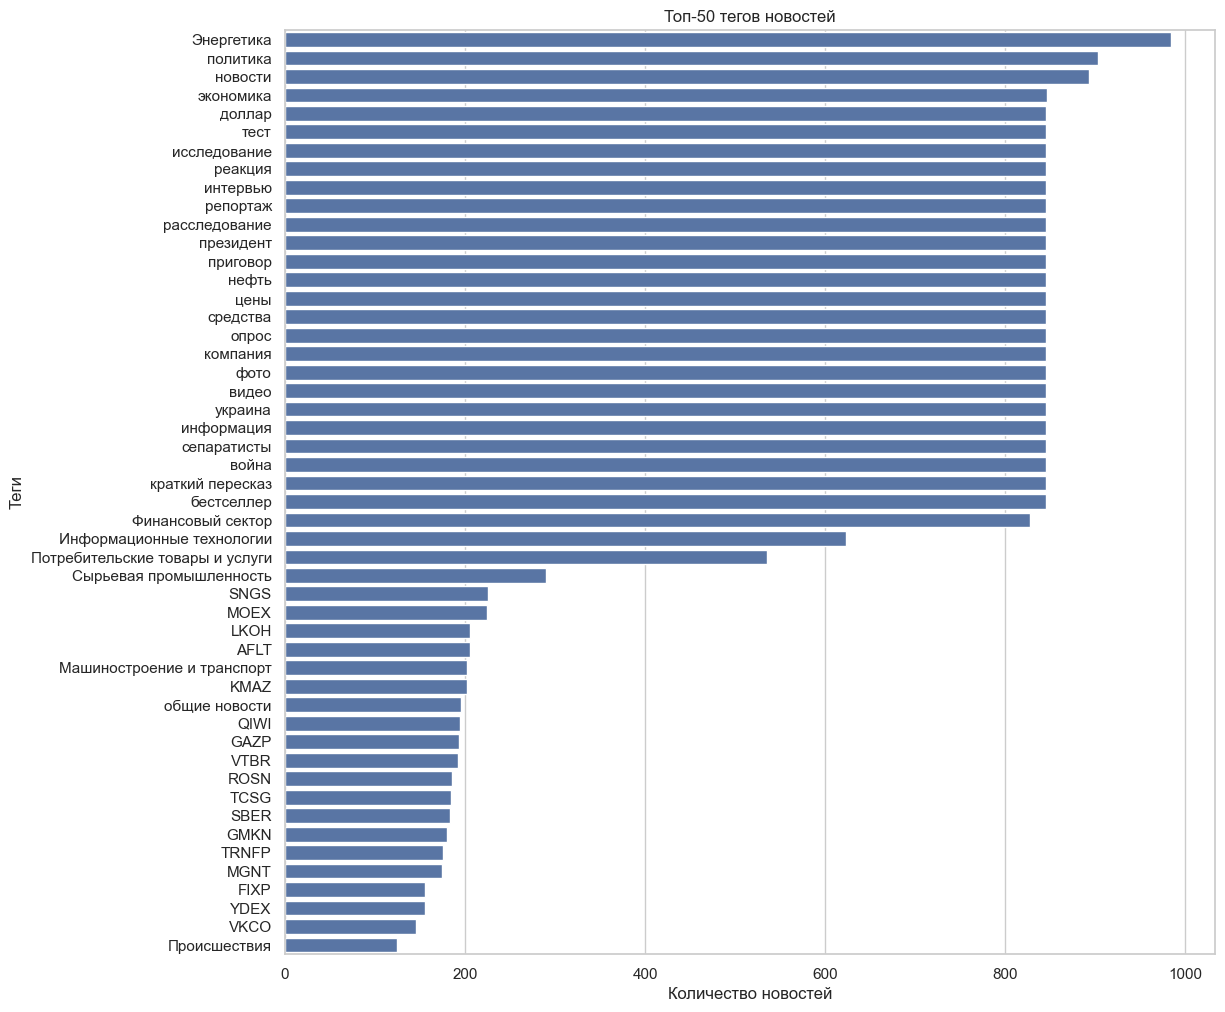

In [44]:
tags_series = df['tags'].str.split(', ')
tags_exploded = tags_series.explode()

# Получаем топ-20 тегов
top_tags = tags_exploded.value_counts().nlargest(50)

plt.figure(figsize=(12, 12))
sns.countplot(y=tags_exploded[tags_exploded.isin(top_tags.index)], order=top_tags.index)
plt.title('Топ-50 тегов новостей')
plt.xlabel('Количество новостей')
plt.ylabel('Теги')
plt.show()

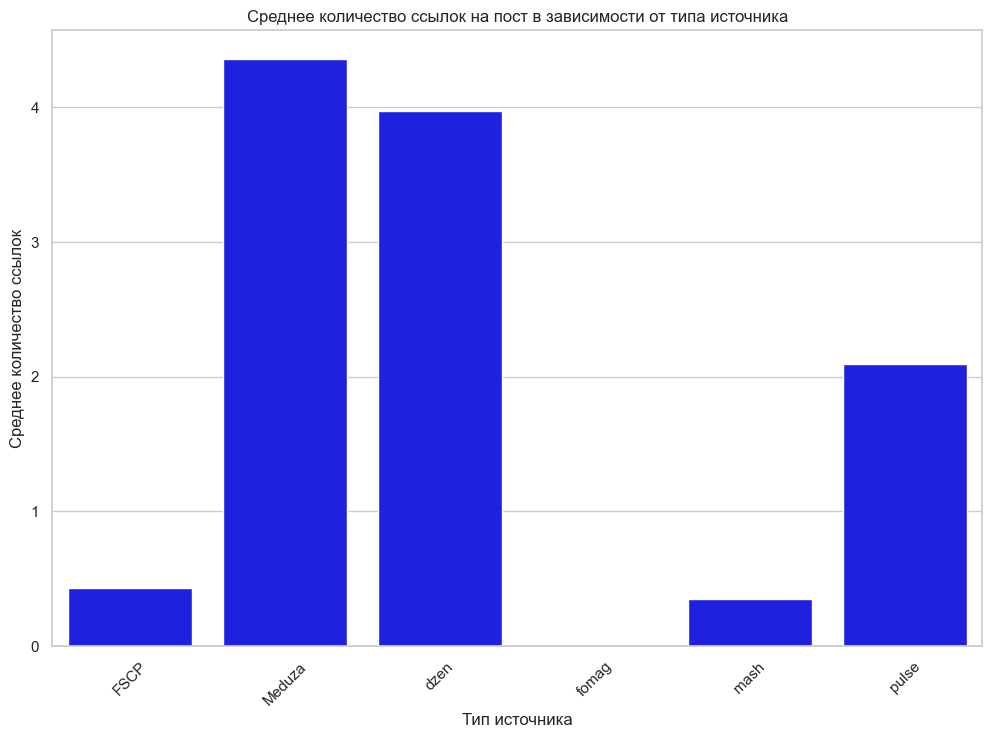

In [45]:
# среднее количество ссылок для каждого source_type
df['link_count'] = df['post_links'].apply(len)
average_links = df.groupby('source_type')['link_count'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=average_links, x='source_type', y='link_count', color='blue') 
plt.title('Среднее количество ссылок на пост в зависимости от типа источника')
plt.xlabel('Тип источника')
plt.ylabel('Среднее количество ссылок')
plt.xticks(rotation=45)
plt.show()


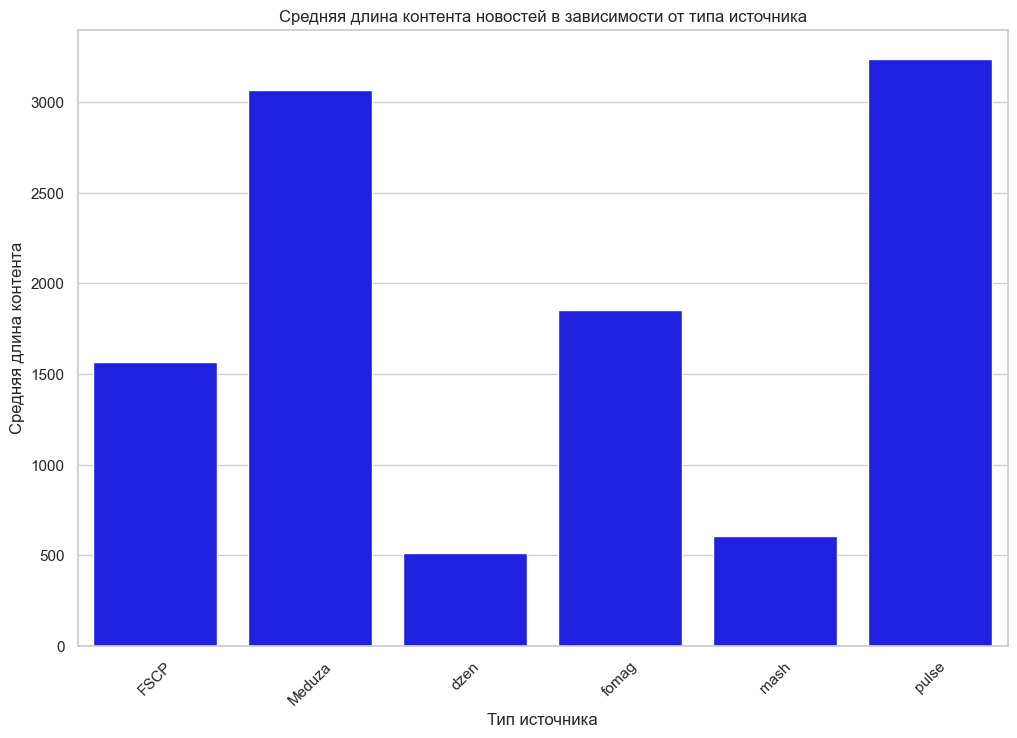

In [46]:
df['content_length'] = df['content'].astype(str).apply(len)

# Вычисляем среднюю длину контента для каждого source_type
average_content_length = df.groupby('source_type')['content_length'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=average_content_length, x='source_type', y='content_length', color='blue')  # Укажите цвет
plt.title('Средняя длина контента новостей в зависимости от типа источника')
plt.xlabel('Тип источника')
plt.ylabel('Средняя длина контента')
plt.xticks(rotation=45)
plt.show()

In [47]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc, return_list=False):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    
    for token in doc.split():
        token = token.strip()
        
        if token and token not in stopwords_ru and token[0] != '@' and not token.isascii():
            normal_forms = morph.normal_forms(token)
            if len(normal_forms) > 0:
                token = normal_forms[0]
            tokens.append(token)
    
    if len(tokens) > 0:
        return tokens if return_list else ' '.join(tokens)
    
    return ""


[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
data_ = df.copy()
data_["content"] = data_["content"].apply(lambda x: lemmatize(x))

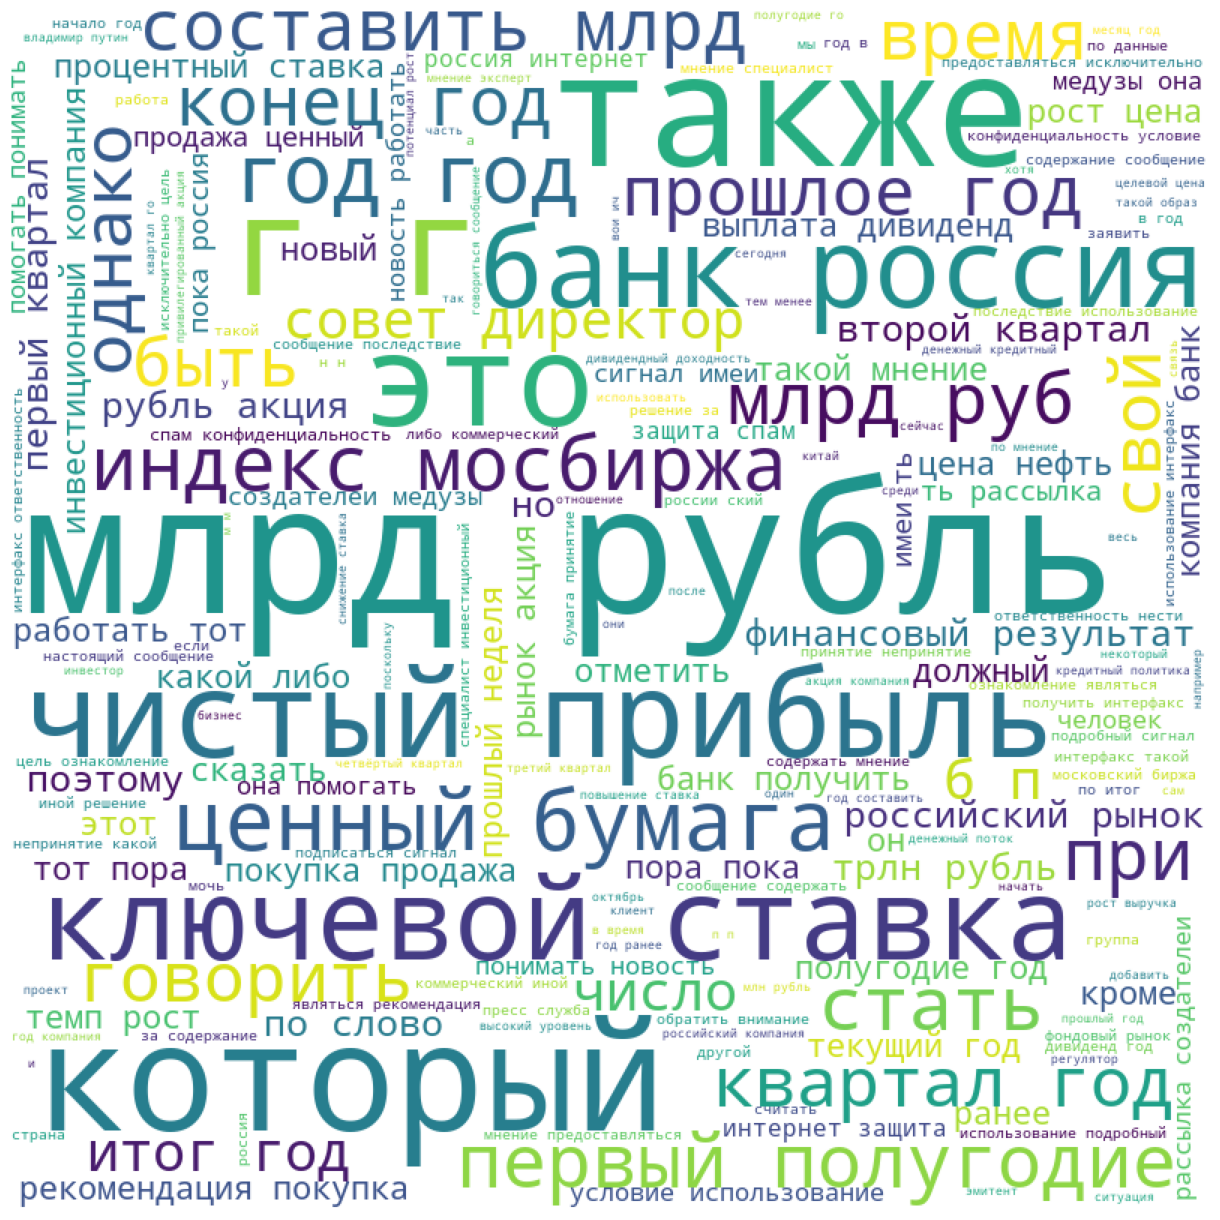

In [71]:
text = ''
stopwords = set(STOPWORDS)

for text_sample in data_["content"]:
    text += f" {text_sample.lower()}"

transformed_text = text.replace(r"\n", "").replace(r"\t", "")

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords
                ).generate(transformed_text)

# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

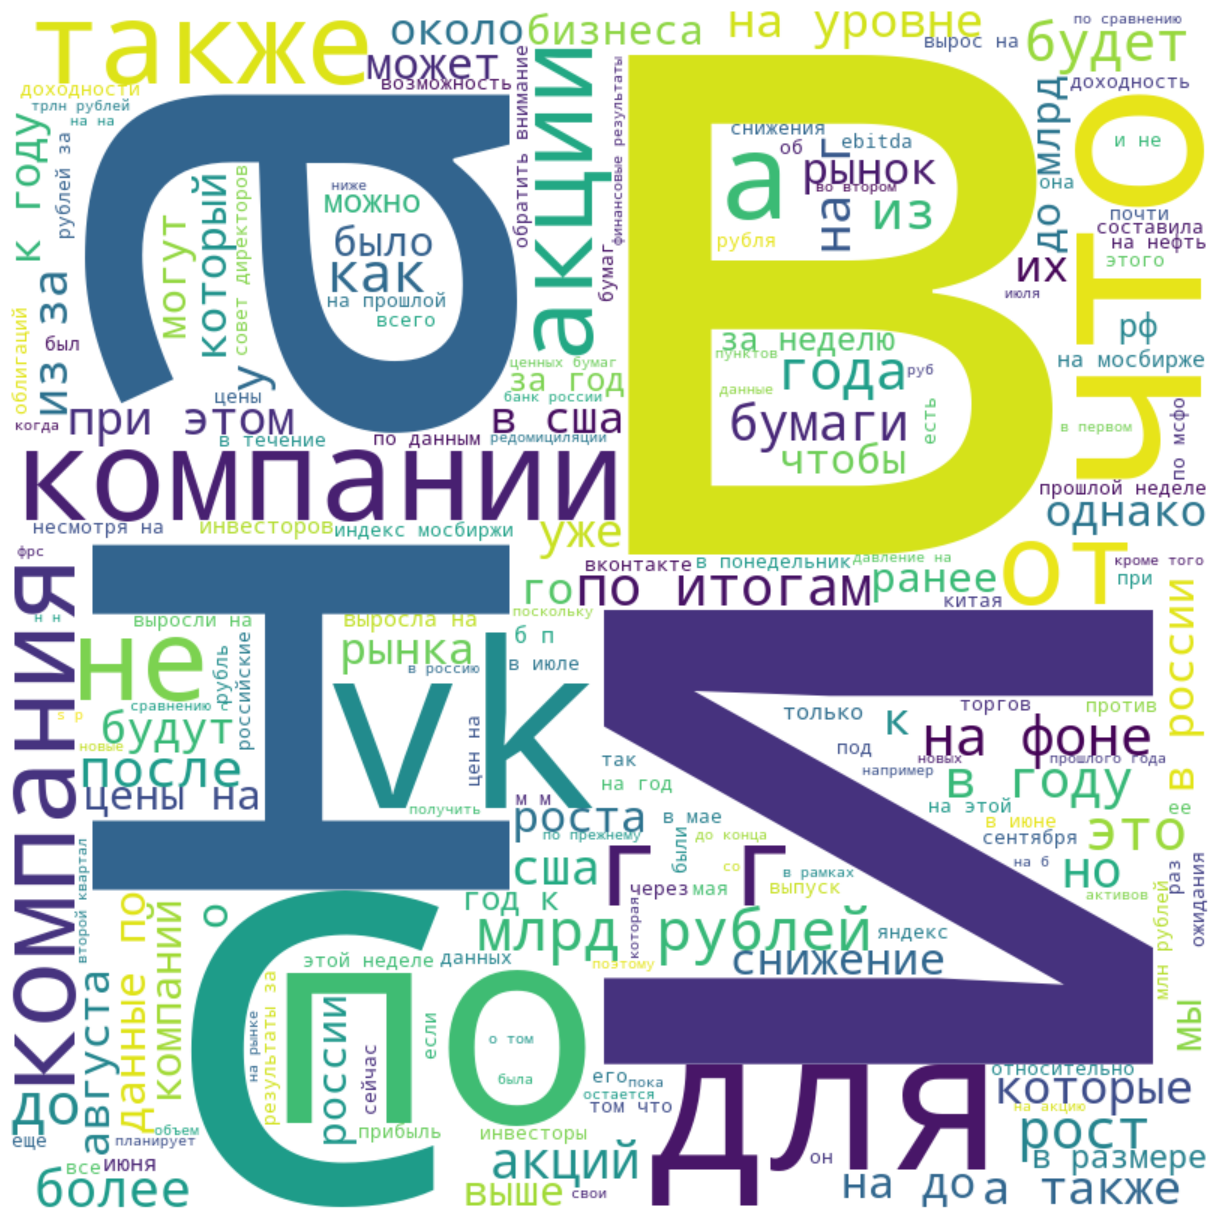

In [64]:

text = ''
stopwords = set(STOPWORDS)
FILTER_TAG =  "VKCO" # "sport" etc

for _, sample in df.iterrows():
    tags = sample["tags"]
    if isinstance(tags, (list, str)) and FILTER_TAG  in tags:
        text += f" {str(sample['content']).lower()}"

# Clean the text
transformed_text = text.replace(r"\n", "").replace(r"\t", "")

# Generate the WordCloud
wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white',
    stopwords=stopwords
).generate(transformed_text)

# Plot the WordCloud image
plt.figure(figsize=(12,12), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [57]:
transformed_data = data_.copy()
transformed_data["word_length"] = transformed_data["content"].apply(lambda x: len(x.split()))
transformed_data["char_length"] = transformed_data["content"].apply(lambda x: len(x))

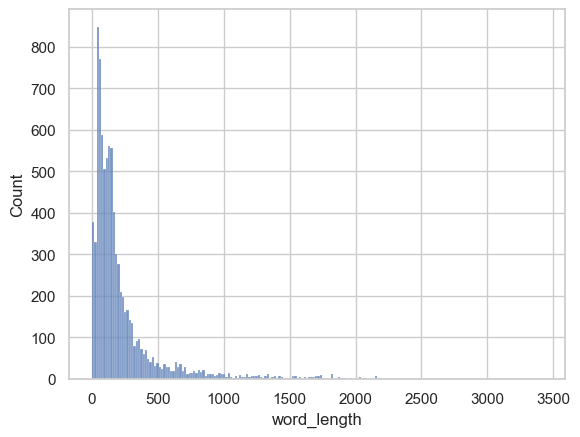

<Figure size 1600x800 with 0 Axes>

In [65]:
sns.histplot(transformed_data, x="word_length")
plt.figure(figsize=(16, 8))
plt.show()

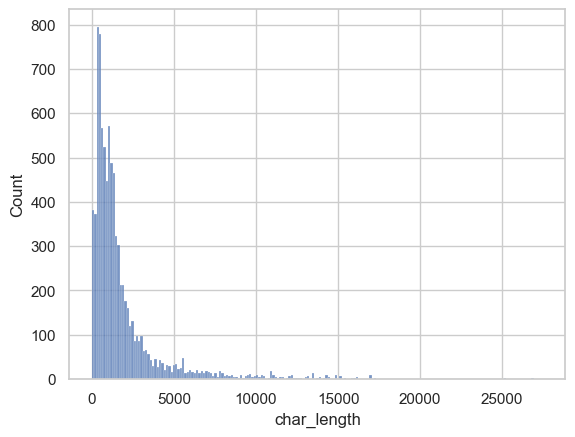

<Figure size 1600x800 with 0 Axes>

In [66]:
sns.histplot(transformed_data, x="char_length")
plt.figure(figsize=(16, 8))
plt.show()

In [73]:
ngram_len = 2
counter = Counter(ngrams(transformed_text.split(), ngram_len))
counter.most_common(15)
values_dict = {" ".join(k): v for k, v in counter.most_common(15)}

<Axes: >

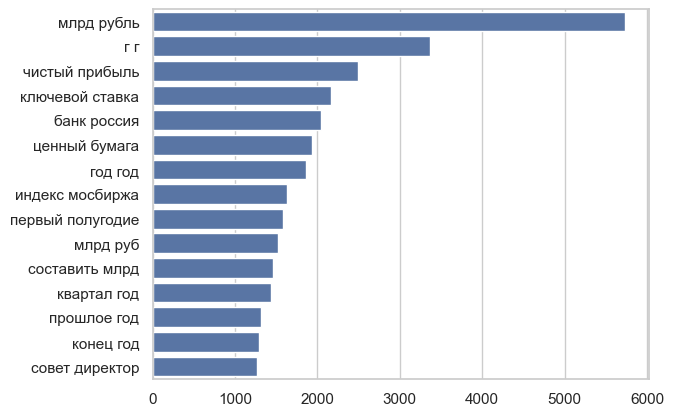

In [74]:
sns.barplot(x=values_dict.values(), y=values_dict.keys(), orient='h')

In [78]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 392.0 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 805.8 kB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [79]:
text = ""
data_ = data_.sample(data_.shape[0])
for text_sample in data_["content"][:1000]:
    text += f" {text_sample.lower()}"

transformed_text = text.replace(r"\n", "").replace(r"\t", "")

ru_news = spacy.load("ru_core_news_sm")
ru_news.max_length = 2057123
doc = ru_news(transformed_text)
tokens_entities = [(token.text, token.ent_type_) for token in doc]

In [81]:
tokens_entities_ = [item for item in tokens_entities if item[1] != ""]
tokens_entities_[:100]

[('венгрия', 'LOC'),
 ('виктор', 'PER'),
 ('орбан', 'PER'),
 ('москва', 'LOC'),
 ('внуково', 'ORG'),
 ('ес', 'LOC'),
 ('жозеп', 'PER'),
 ('боррель', 'PER'),
 ('брюссель', 'LOC'),
 ('венгрия', 'LOC'),
 ('владимир', 'PER'),
 ('путин', 'PER'),
 ('ноэль', 'PER'),
 ('рандевич', 'PER'),
 ('сюзанна', 'PER'),
 ('узбекистан', 'LOC'),
 ('сми', 'ORG'),
 ('узбекистан', 'LOC'),
 ('шавкат', 'PER'),
 ('мирзией', 'PER'),
 ('узбекистан', 'LOC'),
 ('ао', 'ORG'),
 ('узавтосаноат', 'PER'),
 ('узавтопром', 'PER'),
 ('ао', 'PER'),
 ('узавтосаноат', 'PER'),
 ('узбекистан', 'LOC'),
 ('рф', 'LOC'),
 ('владимир', 'PER'),
 ('путин', 'PER'),
 ('узбекистан', 'LOC'),
 ('россия', 'LOC'),
 ('узбекистан', 'LOC'),
 ('ташкентский', 'ORG'),
 ('металлургический', 'ORG'),
 ('завод', 'ORG'),
 ('ташкентский', 'LOC'),
 ('джизакский', 'LOC'),
 ('область', 'LOC'),
 ('россия', 'LOC'),
 ('путин', 'PER'),
 ('китай', 'LOC'),
 ('ао', 'ORG'),
 ('узбекистан', 'LOC'),
 ('ооо', 'PER'),
 ('самавто', 'PER'),
 ('втб', 'ORG'),
 ('оск', 'ORG

In [82]:
tokens_entities_df = pd.DataFrame(tokens_entities_, columns=["text", "entity"])

In [85]:
all_words = ' '.join(df['content'].dropna()).lower().split()

stop_word_counts = Counter(word for word in all_words if word in stopwords_ru)

top_10_stop_words = stop_word_counts.most_common(10)

print("Топ-10 самых частых стоп-слов:\n")
for word, freq in top_10_stop_words:
    print(f"{word}: {freq}")

Топ-10 самых частых стоп-слов:

в: 107439
на: 81801
и: 63360
по: 32441
с: 30121
что: 25647
за: 19822
не: 19493
до: 15278
к: 14339


In [7]:
nltk.download('stopwords')
stopwords_ru = set(stopwords.words("russian"))

# Функция для обработки текста
def calculate_stopwords_statistics(text, stopwords_set):
    # Разбиваем текст на предложения
    sentences = re.split(r'[.!?]+', text)
    total_words = 0
    total_stopwords = 0
    total_words_no_stop = 0
    sentence_lengths_with_stop = []
    sentence_lengths_without_stop = []
    
    for sentence in sentences:
        # Разбиваем предложение на слова
        words = re.findall(r'\w+', sentence.lower())
        total_words += len(words)
        
        # Считаем количество стоп-слов в предложении
        stopword_count = sum(1 for word in words if word in stopwords_set)
        non_stopword_count = len(words) - stopword_count
        
        total_stopwords += stopword_count
        total_words_no_stop += non_stopword_count

        # Сохраняем длину предложений
        sentence_lengths_with_stop.append(len(words))
        sentence_lengths_without_stop.append(non_stopword_count)
    
    # Рассчитываем статистику
    stopword_ratio = total_stopwords / total_words if total_words else 0
    avg_sentence_length_with_stop = sum(sentence_lengths_with_stop) / len(sentence_lengths_with_stop) if sentence_lengths_with_stop else 0
    avg_sentence_length_without_stop = sum(sentence_lengths_without_stop) / len(sentence_lengths_without_stop) if sentence_lengths_without_stop else 0

    return stopword_ratio, avg_sentence_length_with_stop, avg_sentence_length_without_stop

# Рассчитываем статистику для всего корпуса
stopword_ratios = []
avg_sentence_lengths_with_stop = []
avg_sentence_lengths_without_stop = []

for content in df['content'].dropna():
    stopword_ratio, avg_length_with_stop, avg_length_without_stop = calculate_stopwords_statistics(content, stopwords_ru)
    stopword_ratios.append(stopword_ratio)
    avg_sentence_lengths_with_stop.append(avg_length_with_stop)
    avg_sentence_lengths_without_stop.append(avg_length_without_stop)

# Средние значения для всего корпуса
overall_stopword_ratio = sum(stopword_ratios) / len(stopword_ratios) if stopword_ratios else 0
overall_avg_sentence_length_with_stop = sum(avg_sentence_lengths_with_stop) / len(avg_sentence_lengths_with_stop) if avg_sentence_lengths_with_stop else 0
overall_avg_sentence_length_without_stop = sum(avg_sentence_lengths_without_stop) / len(avg_sentence_lengths_without_stop) if avg_sentence_lengths_without_stop else 0

print(f"Доля стоп-слов в корпусе: {overall_stopword_ratio:.2%}")
print(f"Средняя длина предложения со стоп-словами: {overall_avg_sentence_length_with_stop:.2f}")
print(f"Средняя длина предложения без стоп-слов: {overall_avg_sentence_length_without_stop:.2f}")

[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Доля стоп-слов в корпусе: 22.95%
Средняя длина предложения со стоп-словами: 13.70
Средняя длина предложения без стоп-слов: 10.44


In [11]:
import pymorphy2

nltk.download('stopwords')
stopwords_ru = set(stopwords.words("russian"))
morph = pymorphy2.MorphAnalyzer()

# Функция для определения частей речи
def get_pos_frequencies(text, stopwords_set, morph_analyzer):
    words = re.findall(r'\w+', text.lower())
    pos_counts = Counter()

    for word in words:
        # Пропускаем стоп-слова и англоязычные слова
        if word in stopwords_set or word.isascii():
            continue

        # Определяем нормальную форму слова и его часть речи
        parsed_word = morph_analyzer.parse(word)[0]
        pos = parsed_word.tag.POS  # получаем часть речи
        if pos:  # если POS определена
            pos_counts[pos] += 1

    return pos_counts

# Считаем частоты частей речи для всего корпуса
pos_counter = Counter()

for content in df['content'].dropna():
    pos_counts = get_pos_frequencies(content, stopwords_ru, morph)
    pos_counter.update(pos_counts)

# Находим 10 наиболее частых частей речи
most_common_pos = pos_counter.most_common(10)

# Выводим результаты
print("Наиболее частые части речи:")
for pos, freq in most_common_pos:
    print(f"{pos}: {freq}")

[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Наиболее частые части речи:
NOUN: 1129361
ADJF: 304488
VERB: 212058
ADVB: 53389
INFN: 50643
PRTF: 24382
PRCL: 23044
PREP: 17072
PRTS: 13328
ADJS: 11724


In [13]:
nltk.download('stopwords')
stopwords_ru = set(stopwords.words("russian"))

# Функция для очистки и подсчета слов
def get_word_frequencies(text, stopwords_set):
    # Приведение текста к нижнему регистру и удаление спецсимволов
    words = re.findall(r'\w+', text.lower())
    # Исключение стоп-слов и англоязычных слов
    words = [word for word in words if word not in stopwords_set and not word.isascii()]
    # Подсчет частот слов
    return Counter(words)

# Объединение текстов и подсчет частот для всего корпуса
word_counter = Counter()

for content in df['content'].dropna():
    word_counts = get_word_frequencies(content, stopwords_ru)
    word_counter.update(word_counts)

# Находим 10 наиболее популярных слов
most_common_words = word_counter.most_common(10)

# Выводим результаты
print("Самые популярные слова по встречаемости:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Самые популярные слова по встречаемости:
года: 16333
рублей: 10974
компании: 9826
млрд: 9720
это: 8669
россии: 8621
также: 8414
году: 7998
г: 6858
год: 6127
